In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import shap as sh

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LogisticRegression

# ✅Загрузим данные и проведем EDA

<b>EDA(Exploring Data Analysys)</b> - разведочный анализ данных. Применяется для "знакомства" с данными. Во время EDA нас в первую очередь интересуют типы данных(число/строка/время), заполняемость данных, корреляция признаков между собой и целевой переменной, распределение признаков. Подробно про EDA расписано <a href='https://habr.com/ru/companies/otus/articles/752434/'>тут</a>, советую почитать и поиграться на досуге😋.

<b>О данных - </b> в этом ноутбуке мы будем решать сначала задачу регрессии, а затем и задачу классификации для датасета "Титаника" - в нем собранна информация о пассажирах печально известного затонувшего корабля(оригинальный датасет и полное его описание <a href='https://www.kaggle.com/datasets/yasserh/titanic-dataset'>туть</a>). В задаче регрессии будем предсказывать возраст пассажиров, а в задаче классификации выжил пассажир или нет при катастрофе.

In [2]:
# считаем заранее скачанных датасет
dataset = pd.read_csv('Titanic-Dataset.csv')

In [3]:
# посмотрим на первые пять строк
dataset.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# выведем информацию о типах данных
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# выведем описательную статистику
# начнем с числовых признаков
dataset.select_dtypes(exclude=['object']).describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# посмотрим статистику по категориальным признакам
dataset.select_dtypes(include=['object']).describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


<Axes: >

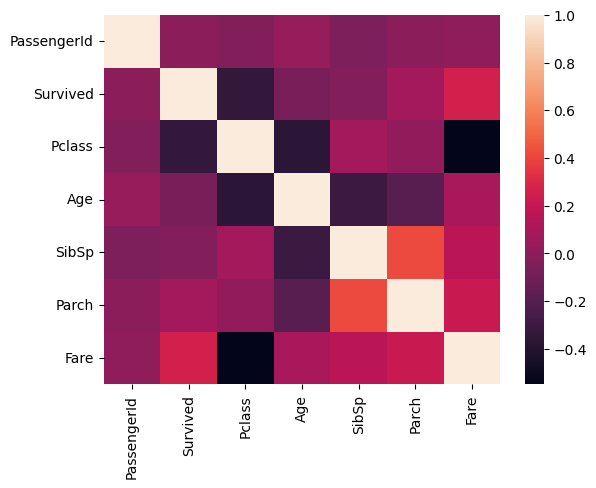

In [7]:
# посмотрим на корреляцию признаков между собой
# особое внимание обращаем на корреляцию с целевыми переменными(возраст и выживание)
sns.heatmap(dataset.select_dtypes(exclude=['object']).corr())

In [8]:
# удалим точно ненужные признаки - id пассажира и его имя
dataset.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

Survived


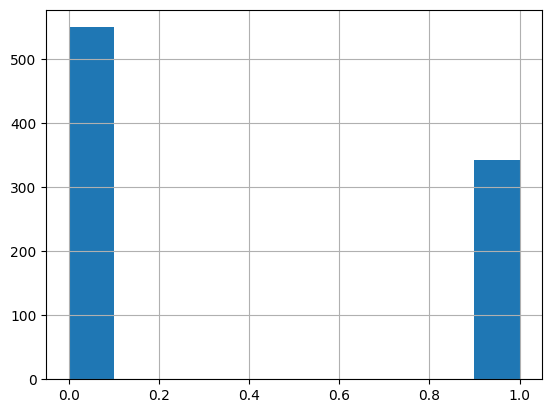

Pclass


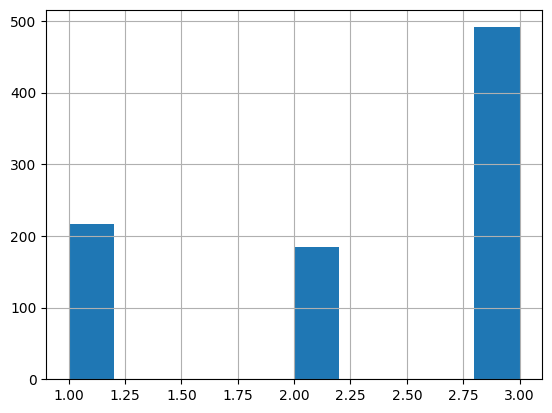

Sex


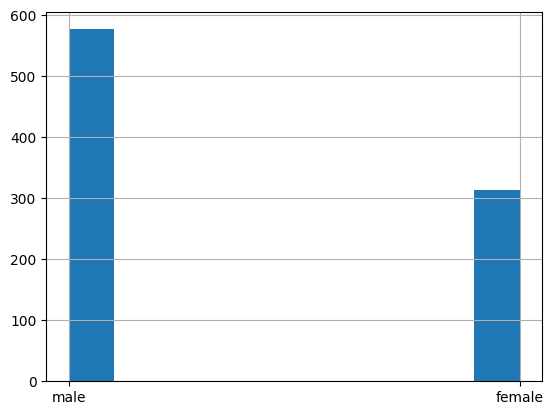

Age


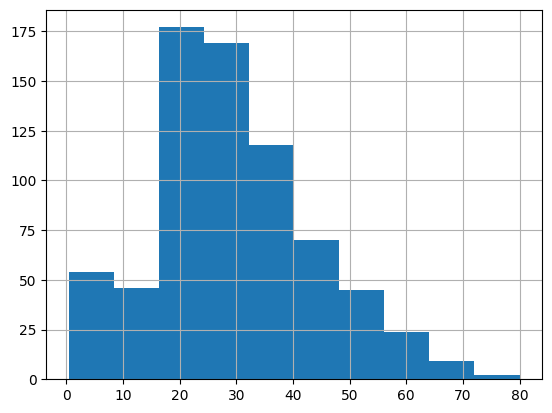

SibSp


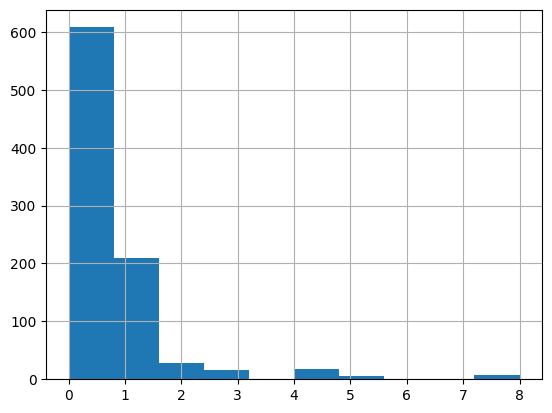

Parch


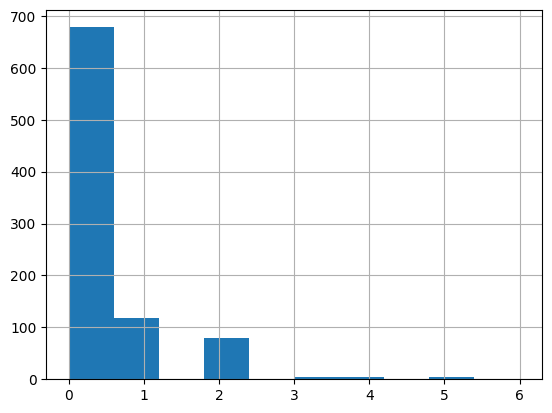

Fare


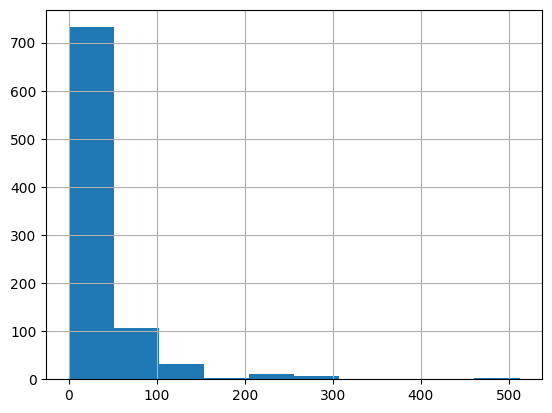

Embarked


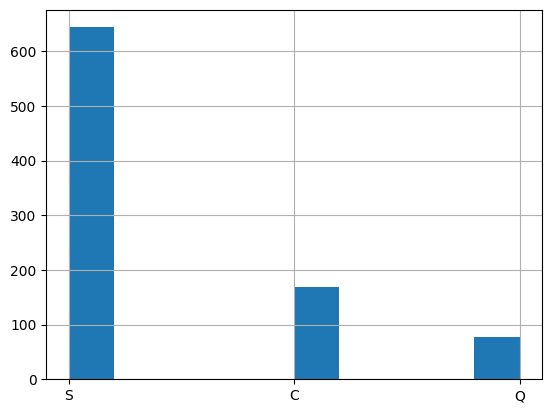

In [9]:
# посмотрим на распределение каждого признака
columns = list(dataset.columns)

for i in range(len(columns)):
    col = columns[i]
    print(col)
    dataset[col].hist()
    plt.show()

# ✅Работа с пропусками

<b>Важно - </b> в каждой задаче машинного обучения свой особенный подход к обработке пропусков. Все время нужно ориентироваться по ситуации. Универсального рецепта не существует🥲. Мы же заполним пропуски значениями, которые точно не входят в исходное распределение признака.

In [10]:
# но сначала проверим, есть ли пропуски вообще - вдруг нам повезло?
dataset.isna().any().any()

True

In [11]:
# пропуски есть, поэтому для начала определим, в каких именно колонках
dataset.isna().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

In [12]:
# очень "интересный" набор пропусков.. В возрасте мы не можем написать что зря, в номере каюты и семейном положении тоже..
# посмотрим, сколько у нас всего значений с пропусками
dataset.dropna().shape

(712, 8)

In [13]:
dataset.shape

(891, 8)

In [14]:
# аж 808... Это очень много.. Поэтому заполним все пропуски -1, чтож поделать(.
dataset.fillna(-1, inplace=True)

In [15]:
# проверим, что пропусков не осталось
dataset.isna().any().any()

False

# ✅Обработка категориальных признаков

<b>Не все</b> модели машинного обучения понимают, что значит пол человека словами - им нужно численное представление этого признака и ему подобных. Тут то на помощь и приходит кодирование! Самый простой способ кодирования состоит в сведении категориальных признаков к бинарным, но он допустим только в том случае, если признак, как в нашем случае пол человека, имеет всего два значения. Поэтому остальные категориальные признаки мы закодируем при помощи One-Hot кодирования. Подробнее можно почитать <a href='https://habr.com/ru/articles/666234/'>тут</a>.

In [16]:
# создадим новый датасет, который будет полностью подходить нам для обучения моделей
dataset_coded = dataset.copy() # Замечания: pandas хранит все датафреймы в оперативной памяти, поэтому не стоит копировать очень большие объемы данных

In [17]:
# отдельно закодируем пол
dataset_coded['Sex'] = np.where(dataset_coded['Sex'] == 'male', 1, 0)

In [18]:
# отберем категориальные признаки для кодирования
cat_features = dataset_coded.drop(['Sex'], axis=1).select_dtypes(include=['object'])
cat_columns = list(cat_features.columns)
dataset_coded.drop(cat_columns, axis=1, inplace=True)

In [19]:
# технический моментик
cat_features.replace(-1, '-1', inplace=True)

In [20]:
# применим One-Hot кодирование
ohe = OneHotEncoder()
ohe.fit(cat_features)

# добавим закодированные данные к остальным
coded_cat_features = pd.DataFrame(ohe.transform(cat_features).toarray(), columns=ohe.get_feature_names_out())
dataset_coded = pd.concat([dataset_coded, coded_cat_features], axis=1)

In [21]:
# проверим, что все получилось
dataset_coded.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_-1,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0.0,0.0,0.0,1.0
1,1,1,0,38.0,1,0,71.2833,0.0,1.0,0.0,0.0
2,1,3,0,26.0,0,0,7.9250,0.0,0.0,0.0,1.0
3,1,1,0,35.0,1,0,53.1000,0.0,0.0,0.0,1.0
4,0,3,1,35.0,0,0,8.0500,0.0,0.0,0.0,1.0


# ✅Стандартизируем наши данные

<b>Основная цель</b> стандартизации данных в приведении их к одинаковой размерности. Для некоторых моделей, в том числе линейных, это является важным этапом, иначе построенная модель лишается своей объективности. Подробнее про стандартизацию можно почитать <a href='https://habr.com/ru/articles/527334/'>туть</a>.

In [22]:
# взглянем на статистику по данным до стандартизации
dataset_coded.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_-1,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,23.600640,0.523008,0.381594,32.204208,0.002245,0.188552,0.086420,0.722783
std,0.486592,0.836071,0.477990,17.867496,1.102743,0.806057,49.693429,0.047351,0.391372,0.281141,0.447876
min,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,6.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,24.000000,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000


In [23]:
standard_scaler = StandardScaler()
standard_scaler.fit(dataset_coded)
dataset_coded = pd.DataFrame(standard_scaler.transform(dataset_coded), columns=standard_scaler.get_feature_names_out())

In [24]:
# проверим, что все окей
dataset_coded.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_-1,Embarked_C,Embarked_Q,Embarked_S
0,-0.789272,0.827377,0.737695,-0.089634,0.432793,-0.473674,-0.502445,-0.047431,-0.482043,-0.307562,0.619306
1,1.266990,-1.566107,-1.355574,0.806350,0.432793,-0.473674,0.786845,-0.047431,2.074505,-0.307562,-1.614710
2,1.266990,0.827377,-1.355574,0.134362,-0.474545,-0.473674,-0.488854,-0.047431,-0.482043,-0.307562,0.619306
3,1.266990,-1.566107,-1.355574,0.638353,0.432793,-0.473674,0.420730,-0.047431,-0.482043,-0.307562,0.619306
4,-0.789272,0.827377,0.737695,0.638353,-0.474545,-0.473674,-0.486337,-0.047431,-0.482043,-0.307562,0.619306


In [25]:
# взглянем на статистику после стандартизации
dataset_coded.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_-1,Embarked_C,Embarked_Q,Embarked_S
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000,8.910000e+02
mean,3.987333e-17,-8.772133e-17,-1.156327e-16,1.754427e-16,4.386066e-17,5.382900e-17,3.987333e-18,3.189866e-17,-1.993666e-17,0.000000,-4.984166e-17
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562,1.000562e+00
min,-7.892723e-01,-1.566107e+00,-1.355574e+00,-1.377611e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,-4.743120e-02,-4.820427e-01,-0.307562,-1.614710e+00
25%,-7.892723e-01,-3.693648e-01,-1.355574e+00,-9.856179e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,-4.743120e-02,-4.820427e-01,-0.307562,-1.614710e+00
50%,-7.892723e-01,8.273772e-01,7.376951e-01,2.236377e-02,-4.745452e-01,-4.736736e-01,-3.573909e-01,-4.743120e-02,-4.820427e-01,-0.307562,6.193064e-01
75%,1.266990e+00,8.273772e-01,7.376951e-01,6.383526e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,-4.743120e-02,-4.820427e-01,-0.307562,6.193064e-01
max,1.266990e+00,8.273772e-01,7.376951e-01,3.158307e+00,6.784163e+00,6.974147e+00,9.667167e+00,2.108317e+01,2.074505e+00,3.251373,6.193064e-01


# ✅Подготовим выборки

In [26]:
# подготовим выборки для тренировки и тестирования моделей
target = dataset_coded['Age']
X_train, X_test, y_train, y_test = train_test_split(dataset_coded.drop(['Age'], axis=1), target, test_size=0.3, random_state=12)

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((623, 10), (623,), (268, 10), (268,))

# ✅Обучим модели регрессии!

In [28]:
# для начала обучим baseline модель - она нужна нам, чтобы смотреть, что мы действительно обучаемся
# за baseline моделью в нашем случае не стоит ничего серьезного - наша baseline модель будет просто предсказывать среднее по всей выборке
baseline_regressor = DummyRegressor(strategy='mean')
baseline_regressor.fit(X_train, y_train)

DummyRegressor()

In [29]:
# посмотрим на ошибку нашего простого регрессора
baseline_prediction = baseline_regressor.predict(X_test)
print('RMSE baseline модели: ', root_mean_squared_error(y_test, baseline_prediction))

RMSE baseline модели:  1.0389512041352376


<b>Неплохо</b> для baseline модели - это значит, что наша модель сейчас ошибается примерно на год. Попробуем улучшить этот результат!

In [30]:
# Обучим простую линейную регрессию
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

LinearRegression()

In [31]:
# посмотрим на ошибку линейной регрессии
linear_regression_prediction = linear_regression.predict(X_test)
print('RMSE линейной регрессии: ', root_mean_squared_error(y_test, linear_regression_prediction))

RMSE линейной регрессии:  0.9205947716095942


<b>Уже</b> лучше! Продолжим в том же духе!

<b>Перед тем, как</b> рассмотреть еще две модели регрессии, стоит ввести понятия переобучения и регуляризации. Тема обширная, поэтому рекомендую почитать самому <a href='https://habr.com/ru/companies/otus/articles/860958/'>туть</a>.

In [32]:
# посмотрим, не переобучилась ли наша модель
linear_regression_prediction_train = linear_regression.predict(X_train)
linear_regression_prediction_test = linear_regression.predict(X_test)
train_error = root_mean_squared_error(y_train, linear_regression_prediction_train)
test_error = root_mean_squared_error(y_test, linear_regression_prediction_test)
print('RMSE линейной регрессии на train: ', train_error)
print('RMSE линейной регрессии на test: ', test_error)
print('Delta: ', test_error - train_error)

RMSE линейной регрессии на train:  0.8832966609283665
RMSE линейной регрессии на test:  0.9205947716095942
Delta:  0.03729811068122779


<b>Повезло!</b> В нашем случае переобучение практически отсутствует, но мы все равно попытаемся уменьшить дельту!

In [33]:
# построим регрессию с L1 регуляризацией
lasso_regression = Lasso()
lasso_regression.fit(X_train, y_train)

Lasso()

In [34]:
# построим регрессию с L2 регуляризацией
ridge_regression = Ridge()
ridge_regression.fit(X_train, y_train)

Ridge()

In [35]:
# Посмотрим на метрики и выберем лучшую модель
linear_regression_prediction_train = linear_regression.predict(X_train)
linear_regression_prediction_test = linear_regression.predict(X_test)
train_error = root_mean_squared_error(y_train, linear_regression_prediction_train)
test_error = root_mean_squared_error(y_test, linear_regression_prediction_test)

print('RMSE линейной регрессии на train: ', train_error)
print('RMSE линейной регрессии на test: ', test_error)
print('Delta линейной регрессии: ', test_error - train_error)
print()

lasso_regression_prediction_train = lasso_regression.predict(X_train)
lasso_regression_prediction_test = lasso_regression.predict(X_test)
train_error_lasso = root_mean_squared_error(y_train, lasso_regression_prediction_train)
test_error_lasso = root_mean_squared_error(y_test, lasso_regression_prediction_test)

print('RMSE L1 регрессии на train: ', train_error_lasso)
print('RMSE L1 регрессии на test: ', test_error_lasso)
print('Delta L1 регрессии: ', test_error_lasso - train_error_lasso)
print()

ridge_regression_prediction_train = ridge_regression.predict(X_train)
ridge_regression_prediction_test = ridge_regression.predict(X_test)
train_error_ridge = root_mean_squared_error(y_train, ridge_regression_prediction_train)
test_error_ridge = root_mean_squared_error(y_test, ridge_regression_prediction_test)

print('RMSE L2 регрессии на train: ', train_error_ridge)
print('RMSE L2 регрессии на test: ', test_error_ridge)
print('Delta L2 регрессии: ', test_error_ridge - train_error_ridge)
print()

RMSE линейной регрессии на train:  0.8832966609283665
RMSE линейной регрессии на test:  0.9205947716095942
Delta линейной регрессии:  0.03729811068122779

RMSE L1 регрессии на train:  0.9848421671712555
RMSE L1 регрессии на test:  1.0389512041352376
Delta L1 регрессии:  0.05410903696398206

RMSE L2 регрессии на train:  0.8832971498015699
RMSE L2 регрессии на test:  0.9206229720989282
Delta L2 регрессии:  0.03732582229735826



# ✅Тьюн модели

<b>Тьюн</b> модели нужен для подбора оптимальных гиперпараметров модели. Есть разные подходы к его реализации. Мы сделаем поиск по сетке.<br>
<b>ВНИМАНИЕ!</b> Если автор не сказал, в чем различие между обучаемыми параметрами и гиперпараметрами или вы поняли не до конца, в чем их разница, то пишите в личные сообщения!!! Это очень важный момент!!!

In [36]:
# зададим пространство гиперпараметров, среди которых будем искать оптимальные
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [50, 100, 500, 1000],
    'solver': ['auto', 'svd', 'cholesky']
}

ridge_regression = Ridge()

# зададим метрику - по ней будем смотреть качество модели
rmse_metric = make_scorer(root_mean_squared_error)

grid_search = GridSearchCV(ridge_regression, param_grid, cv=5, scoring=rmse_metric, refit=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [50, 100, 500, 1000],
                         'solver': ['auto', 'svd', 'cholesky']},
             scoring=make_scorer(root_mean_squared_error, response_method='predict'))

In [37]:
# Лучшие найденные параметры
print("Best parameters:", grid_search.best_params_)

# Оценка лучшей модели
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'alpha': 0.001, 'max_iter': 50, 'solver': 'auto'}
Best cross-validation score: 0.9048344993314383


In [38]:
# получим ссылку на лучшую модель
best_model = grid_search.best_estimator_

In [39]:
# посмотрим на метрику лучшей модели
ridge_regression_prediction_train = best_model.predict(X_train)
ridge_regression_prediction_test = best_model.predict(X_test)
train_error_ridge = root_mean_squared_error(y_train, ridge_regression_prediction_train)
test_error_ridge = root_mean_squared_error(y_test, ridge_regression_prediction_test)

print('RMSE L2 регрессии на train: ', train_error_ridge)
print('RMSE L2 регрессии на test: ', test_error_ridge)
print('Delta L2 регрессии: ', train_error_ridge - test_error_ridge)
print()

RMSE L2 регрессии на train:  0.8832966609288592
RMSE L2 регрессии на test:  0.9205947992990986
Delta L2 регрессии:  -0.03729813837023943



# ✅Проанализируем результаты работы модели

In [40]:
# для начала взглянем, как модель "взвесила" наши признаки
feature_importance = pd.DataFrame(best_model.coef_, index=dataset_coded.drop(['Age'], axis=1).columns, columns=['weight'])

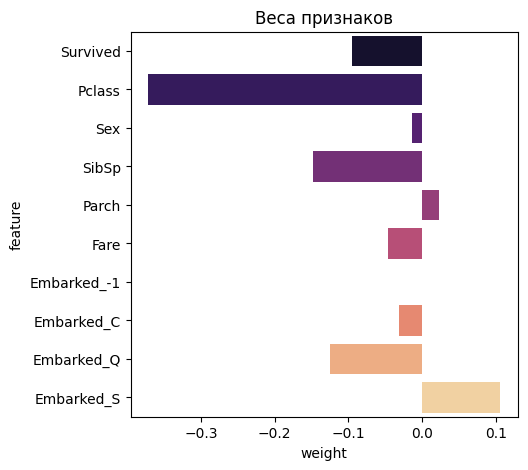

In [41]:
plt.figure(figsize=(5, 5))
sns.barplot(x='weight', y=feature_importance.index, data=feature_importance, palette='magma')
plt.ylabel('feature')
plt.title('Веса признаков')
plt.show()

In [42]:
# а теперь посмотрим, что повлияло на результат модели для каждого человека
# обернем модель в вызываемый объект(ridge в нашем случае таковым не является)
masker = sh.maskers.Independent(data=X_train)
explainer = sh.Explainer(best_model.predict, masker)
shap_values = explainer(X_test)

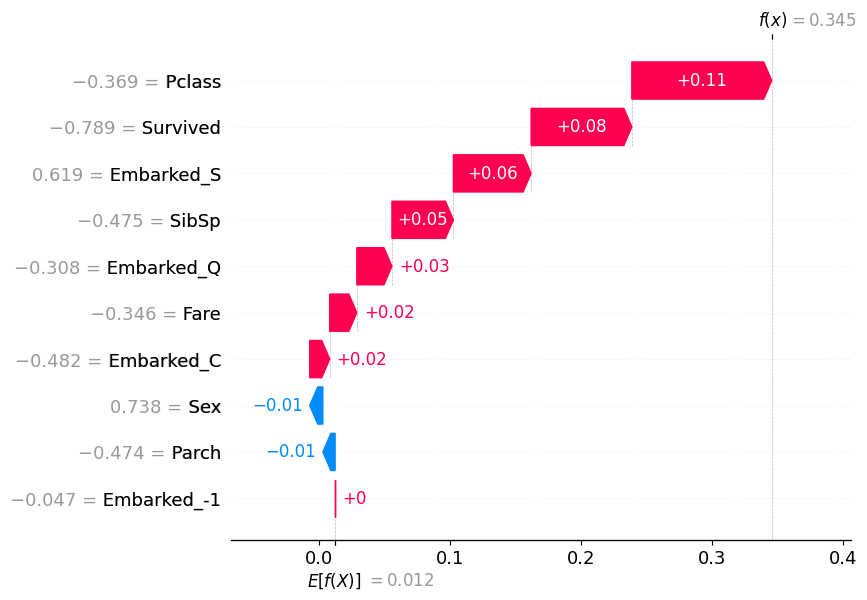

In [43]:
# диаграмма для одного пассажира
sh.plots.waterfall(shap_values[12])

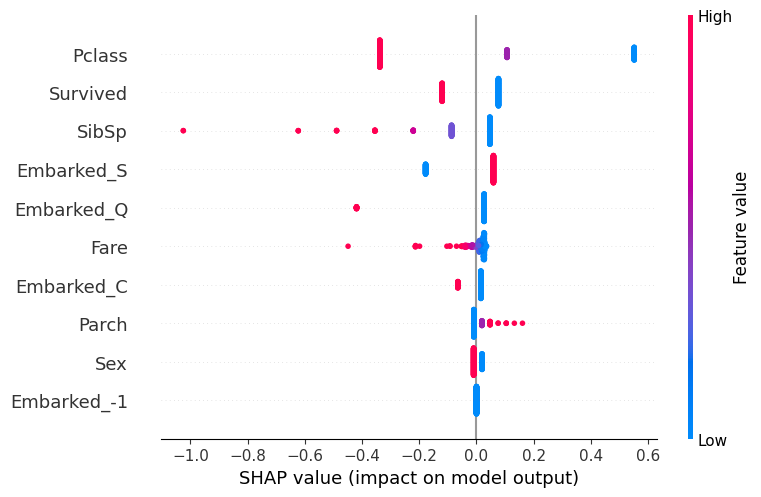

In [44]:
# и для всех пассажиров
sh.plots.beeswarm(shap_values)

# ✅А теперь решим задачу классификации!

После решения задачи регрессии у нас уже имеются готовые для моделирования данные. Теперь попытаемся предсказать, выжил ли пассажир Титаника или же нет

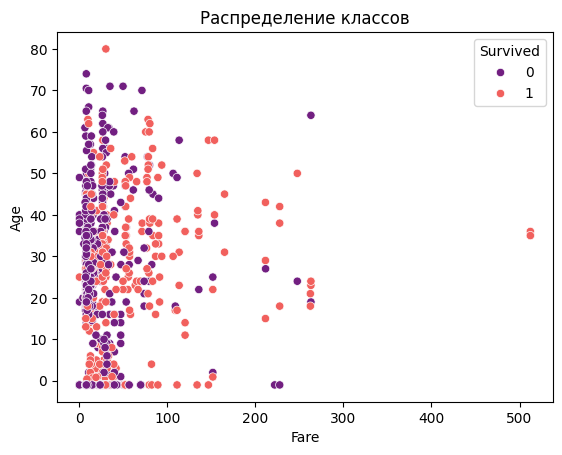

In [45]:
# посмотрим, как распределены классы на плоскости. Для этого возьмем возраст пассажира и стоимость его билета
plot_classes = dataset[['Age', 'Fare', 'Survived']]
sns.scatterplot(data=plot_classes, x=plot_classes['Fare'], y=plot_classes['Age'], hue=plot_classes['Survived'], palette='magma')
plt.title('Распределение классов')
plt.show()

In [46]:
# даа... ситуация тяжелая, но мы попробуем выжать максимум
# начнем с формирования новых выборок
target = dataset['Survived']
X_train, X_test, y_train, y_test = train_test_split(dataset_coded.drop(['Survived'], axis=1), target, test_size=0.3, random_state=12)

# ✅Обучим модели и посмотрим, как они справляются с классификацией

In [47]:
def plot_decision_boundary(model, X, y, f1, f2):
    X = X.copy()
    f1_name, f2_name = f1, f2
    f1, f2 = np.meshgrid(
    np.linspace(X[f1].min() - 1, X[f1].max() + 1),
    np.linspace(X[f2].min() - 1, X[f2].max() + 1)
    )
    
    model.fit(X[[f1_name, f2_name]], y)
    
    grid = np.vstack([f1.ravel(), f2.ravel()]).T
    y_pred = np.reshape(model.predict(grid), f1.shape)
    display = DecisionBoundaryDisplay(xx0=f1, xx1=f2, response=y_pred)
    display.plot()
    X.insert(2, column='target', value=y)
    sns.scatterplot(data=X, x=X[f1_name], y=X[f2_name], hue=X['target'], palette='magma')
    plt.show()

In [48]:
# в качестве стратегии для baseline выберем равномерное распределение
baseline_clf = DummyClassifier(strategy='uniform')
baseline_clf.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [49]:
# посмотрим на ошибку
baseline_prediction = baseline_clf.predict(X_test)
print('Accuracy baseline модели: ', accuracy_score(y_test, baseline_prediction))

Accuracy baseline модели:  0.47761194029850745


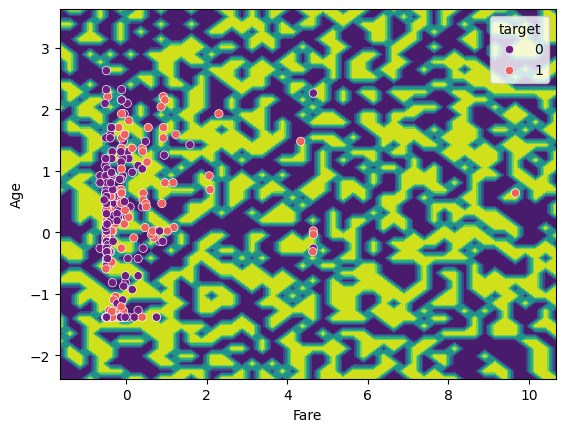

In [50]:
plot_decision_boundary(DummyClassifier(strategy='uniform'), X_test, y_test, 'Fare', 'Age')

In [51]:
# Обучим логистическую регрессию
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [52]:
# посмотрим на ошибку
logistic_regression_prediction = logistic_regression.predict(X_test)
print('Accuracy логистической регрессии: ', accuracy_score(y_test, logistic_regression_prediction))

Accuracy логистической регрессии:  0.7723880597014925


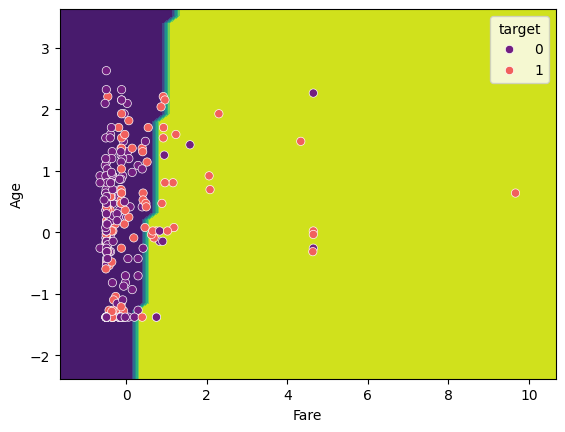

In [53]:
plot_decision_boundary(LogisticRegression(), X_test, y_test, 'Fare', 'Age')

In [54]:
# найдем лучшую модель!
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None]
}

logistic_regression = LogisticRegression()

grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy', refit=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [55]:
# получим ссылку на лучшую модель
best_model = grid_search.best_estimator_

In [56]:
# посмотрим на метрику лучшей модели
prediction_train = best_model.predict(X_train)
prediction_test = best_model.predict(X_test)
train_error = accuracy_score(y_train, prediction_train)
test_error = accuracy_score(y_test, prediction_test)

print('Accuracy на train: ', train_error)
print('Accuracy на test: ', test_error)
print('Delta: ', train_error - test_error)
print()

Accuracy на train:  0.8202247191011236
Accuracy на test:  0.7574626865671642
Delta:  0.0627620325339594



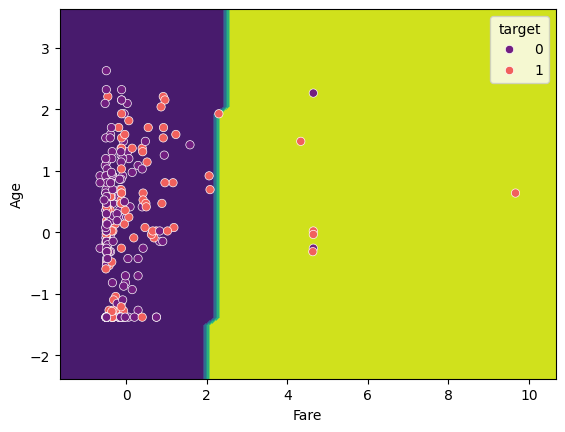

In [57]:
plot_decision_boundary(LogisticRegression(**best_model.get_params()), X_test, y_test, 'Fare', 'Age')

# ✅Проанализируем результаты работы модели

In [58]:
# для начала взглянем, как модель "взвесила" наши признаки
feature_importance = pd.DataFrame(best_model.coef_[0], index=dataset_coded.drop(['Survived'], axis=1).columns, columns=['weight'])

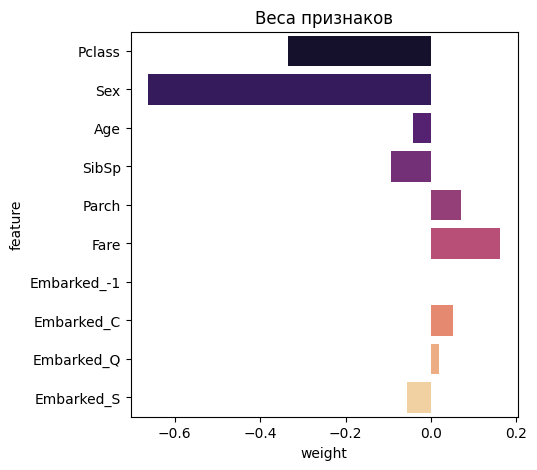

In [59]:
plt.figure(figsize=(5, 5))
sns.barplot(x='weight', y=feature_importance.index, data=feature_importance, palette='magma')
plt.ylabel('feature')
plt.title('Веса признаков')
plt.show()

In [60]:
# а теперь посмотрим, что повлияло на результат модели для каждого человека
# обернем модель в вызываемый объект(ridge в нашем случае таковым не является)
masker = sh.maskers.Independent(data=X_train)
explainer = sh.Explainer(best_model.predict, masker)
shap_values = explainer(X_test)

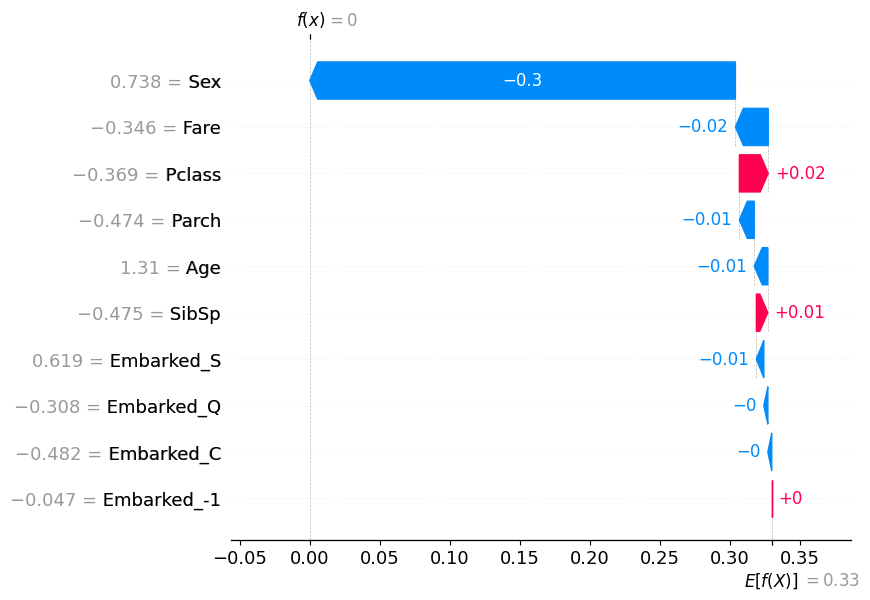

In [61]:
# диаграмма для одного пассажира
sh.plots.waterfall(shap_values[12])

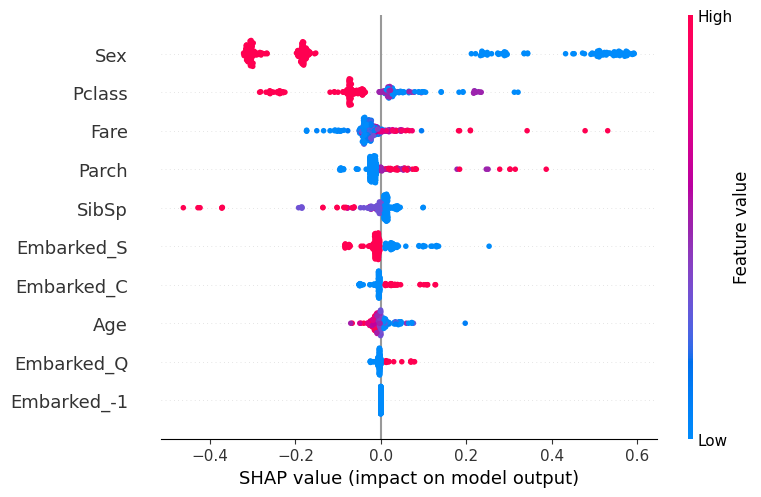

In [62]:
# и для всех пассажиров
sh.plots.beeswarm(shap_values)